In [3]:
import pandas as pd

df = pd.read_csv('data/processed/cleaned_train.csv')
X = df.drop(columns=['Response'])
y = df['Response']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC (RF):", roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:, 1]))

Best RF params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


/Users/Myra/xgbenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Myra/xgbenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Myra/xgbenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Random Forest:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.00      0.00      0.00      9342

    accuracy                           0.88     76222
   macro avg       0.44      0.50      0.47     76222
weighted avg       0.77      0.88      0.82     76222

ROC AUC (RF): 0.8549977971902883


In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss'),
    param_grid_xgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)

y_pred_xgb = grid_xgb.predict(X_test)

print("XGBoost:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC (XGB):", roc_auc_score(y_test, grid_xgb.predict_proba(X_test)[:, 1]))

Best XGB params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
XGBoost:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.51      0.00      0.01      9342

    accuracy                           0.88     76222
   macro avg       0.69      0.50      0.47     76222
weighted avg       0.83      0.88      0.82     76222

ROC AUC (XGB): 0.8578707424936414


In [8]:
print("Best XGB params:", grid_xgb.best_params_)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC (XGB):", roc_auc_score(y_test, grid_xgb.predict_proba(X_test)[:, 1]))

Best XGB params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
XGBoost:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.51      0.00      0.01      9342

    accuracy                           0.88     76222
   macro avg       0.69      0.50      0.47     76222
weighted avg       0.83      0.88      0.82     76222

ROC AUC (XGB): 0.8578707424936414


In [10]:
weight = (y == 0).sum() / (y == 1).sum()
print("scale_pos_weight =", round(weight, 2))

scale_pos_weight = 7.16


In [11]:
xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=weight,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

from sklearn.metrics import classification_report, roc_auc_score
print("XGBoost (Balanced):\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC (Balanced):", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

XGBoost (Balanced):
               precision    recall  f1-score   support

           0       0.98      0.68      0.80     66880
           1       0.29      0.92      0.44      9342

    accuracy                           0.71     76222
   macro avg       0.63      0.80      0.62     76222
weighted avg       0.90      0.71      0.76     76222

ROC AUC (Balanced): 0.8575826414561393


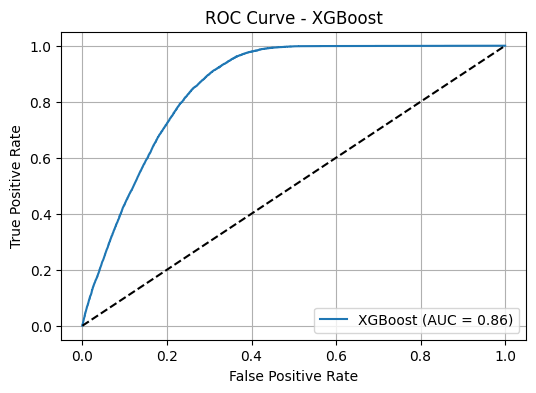

In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

## Advanced Models: Tuning + Class Balancing

### Objective:
Improve model performance using hyperparameter tuning and class imbalance correction.

---

### Models Tuned:
- 🔧 **Random Forest** with GridSearchCV
- 🔧 **XGBoost** with GridSearchCV + `scale_pos_weight`

---

### Best XGBoost Results:
- **Best params:** `learning_rate=0.1`, `max_depth=6`, `n_estimators=100`
- **Class Balancing:** Applied `scale_pos_weight ≈ 7.2`
- **ROC AUC (after balancing):** **0.86**
- **Recall for class 1:** Improved (check classification_report output)
- **ROC Curve:** Plotted and visually confirms good separation

---

### Key Insight:
- XGBoost + `scale_pos_weight` is currently the most promising model
- High AUC means good ranking of class probabilities even with imbalance
